
### 문제  
- 이번 스터디에서 여러분은 음식 배달 서비스를 위한 예측 모델을 만들어야 합니다. 여러분이 예측해야하는 값은  
   **음식 배달에 걸리는 시간**입니다.
- 예측된 배달 시간보다 실제 배달 시간이 더 걸린 경우(under-prediction)가 반대의 경우(over-prediction)보다 두 배로  
  사용자에게 안 좋은 영향을 준다고 알려져 있습니다.
- 여러분은 가능한 한 실제 배달 시간과 가까운 값을 예측하되 동시에 under-prediction을 최소화하는 것이 좋은 예측 모델입니다.
- 또한 여러분은 중간 비워져 있는 **Inline practice**를 수행하셔야 합니다.
<br><br><br><hr>  

### 데이터 설명
- 제가 제공하는 파일인 "delivery.csv"는 다음과 같은 feature들을 가지고 있습니다.
  - 시간 특성
    - created_at : 주문이 생성된 시간의 Timestamp(UTC)
    - actual_delivery_time : 주문자가 배달을 받은 시간의 Timestamp(UTC)
  - 식당 특성
    - market_id : 지역(배달이 이루어지는 도시) 아이디
    - store_id : 식당 아이디
    - store_primary_category : 식당의 카테고리(ex. italian, asian ...)
    - order_protocol : 주문을 받을 수 있는 방식을 나타내는 아이디
  - 주문 특성
    - total_items : 주문에 포함된 음식(item) 개수
    - subtotal : 가격(센트 단위)
    - num_distinct_items : 주문에 포함된 비중복 음식(item)의 개수
    - min_item_price : 주문에 포함된 가장 싼 음식(item)의 가격
    - max_item_price : 주문에 포함된 가장 비싼 음식(item)의 가격
  - 지역 상황 특성
    - total_onshift : 주문이 생성되었을 때 가게로부터 10 마일 이내에 있는 배달원의 수
    - total_busy : 위 배달원 중 주문에 관여하고 있는 사람들의 수
    - total_outstanding_orders : 주문한 가게로부터 10 마일 이내에 있는 다른 주문들의 수
  - 다른 모델들의 예측값 특성
    - estimated_order_place_duration : 식당이 주문을 받을 때까지 걸릴 것으로 예상되는 시간(초 단위)
    - estimated_store_to_consumer_driving_duration : 식당에서 출발해 주문자에게 도착할 때까지 걸릴 것으로 예측되는 시간(초 단위)

※ 위 feature들 중 **actual_delivery_time**을 제외한 모든 속성들을 모델의 입력으로 사용할 수 있습니다.  
※ 모델이 예측해야 하는 값은 actual_delivery_time과 created_at으로 구할 수 있습니다. (초 단위로 표현된 두 feature간의 차이값)  
<br><hr>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<br><br> 

### Get DataFrame
- delivery.csv 파일을 가져옵시다.

In [3]:
df = pd.read_csv('./delivery.csv', sep='\t')
df.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df['created_at']

0         2015-02-06 22:24:17
1         2015-02-10 21:49:25
2         2015-01-22 20:39:28
3         2015-02-03 21:21:45
4         2015-02-15 02:40:36
                 ...         
197423    2015-02-17 00:19:41
197424    2015-02-13 00:01:59
197425    2015-01-24 04:46:08
197426    2015-02-01 18:18:15
197427    2015-02-08 19:24:33
Name: created_at, Length: 197428, dtype: object

<br> 
시간 데이터가 존재합니다. 다만 type가 명시적이지 않으니 type를 datetime 타입으로 변경해주는 작업을 합니다.

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [6]:
df['created_at']

0        2015-02-06 22:24:17
1        2015-02-10 21:49:25
2        2015-01-22 20:39:28
3        2015-02-03 21:21:45
4        2015-02-15 02:40:36
                 ...        
197423   2015-02-17 00:19:41
197424   2015-02-13 00:01:59
197425   2015-01-24 04:46:08
197426   2015-02-01 18:18:15
197427   2015-02-08 19:24:33
Name: created_at, Length: 197428, dtype: datetime64[ns]

<br> <br> 

### 데이터 정제(결측값 처리)
- 결측값이 있는지 확인해봅시다.


In [7]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift                                   16262
total_busy                                      16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

#### **replace**
- ```total_```: 결측값이 많지만, 수치 데이터이고 학습에 중요한 역할을 수행할 것이라 판단하였음.

#### **drop**
- ```market_id``` : 아래와 같이 한 가게가 여러 지역을 맡아서 처리하기 때문에 대치하기 어렵습니다.  
- ```actual_delivery_time```: 예측에 사용할 특성이 정확하지 않으면 학습에 영향이 있을 것으로 판단하였습니다.  
- ```store_primary_category```: 한 가게에서 여러 종류의 음식을 할 수 있으므로 함부로 대치하기 어렵습니다.
- ```estimated_store_to_consumer_driving_duration```: 다른 모델의 예측값입니다. 대치하기 어렵습니다.
- ```order_protocol```: 주문을 받을 수 있는 방식을 나타내는 아이디는 학습에 전혀 상관 없을 것으로 판단하였습니다.

In [8]:
sid = df[df['market_id'].isnull()]['store_id'].unique()
print('store id : {}\nmarket id : {}'.format(sid[1] ,df[df['store_id']==sid[1]]['market_id'].unique()))

store id : 5081
market id : [ 4. nan  1.  2.]


In [9]:
sid = df[df['store_primary_category'].isnull()]['store_id'].unique()
print('store id : {}\nmarket id : {}'.format(sid[1] ,df[df['store_id']==sid[1]]['store_primary_category'].unique()))

store id : 4149
market id : ['sandwich' nan 'thai']


<hr><br>

##### **Inline Practice 1**  

- 데이터를 중간값(median)으로 대치하려고 합니다. 
- sklearn.impute의 SimpleImputer를 사용하여 데이터를 **replace**하는 impute_total_value() 메소드를 작성하세요.

<br><hr>

In [10]:
# 데이터 대치
from sklearn.impute import SimpleImputer

def impute_total_value(df):
    '''
    impute kinds of total_ values with median
    use sklearn.imputer
    '''

    imputer_mid = SimpleImputer(strategy='median', missing_values=np.nan)
    
    imputer_mid = imputer_mid.fit(df[['total_onshift', 'total_busy', 'total_outstanding_orders']])
    df[['total_onshift', 'total_busy', 'total_outstanding_orders']] = imputer_mid.transform(df[['total_onshift', 'total_busy', 'total_outstanding_orders']])

    '''
    imputer_mid = imputer_mid.fit(df[['total_busy']])
    df[['total_busy']] = imputer_mid.transform(df[['total_busy']])

    imputer_mid = imputer_mid.fit(df[['total_outstanding_orders']])
    df[['total_outstanding_orders']] = imputer_mid.transform(df[['total_outstanding_orders']])
    '''
    
    return df


replace와 drop를 수행합니다.

In [11]:
df = impute_total_value(df)
df = df.dropna()
df.isnull().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift                                   0
total_busy                                      0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

#### **Featrue selection and Feature extraction**
학습에 필요한 Feature를 생성해줍시다.  
필요하다면 만들어주는 작업도 수행할 것입니다.

- 배달에 걸린시간 : `actual_delivery_time` - `create_at`
- 주문 시간 : 주문자가 주문을 한 시간에 따라 배달 시간에 차이가 있을 것으로 예상합니다. (peak time)
- 타 모델의 배달에 걸린시간 예측값 : `estimated_order_place_duration` + `estimated_store_to_consumer_driving_duration`**

In [12]:
# 배달에 걸린 시간
def calculate_delivery_time(df):
    df.loc[:,'delivery_time'] = df.loc[:,'actual_delivery_time'] - df.loc[:,'created_at']
    df.loc[:,'delivery_time'] = df.loc[:,'delivery_time'].dt.total_seconds().astype(float)

calculate_delivery_time(df)
df['delivery_time'].head()

0     3779.0
1     4024.0
8     1586.0
14    2273.0
15    2988.0
Name: delivery_time, dtype: float64

In [13]:
# 고객이 주문을 요청한 시각
def make_ordered_time(df):
    df['ordered_time'] = df['created_at'].apply(lambda x: x.hour)

make_ordered_time(df)
df['ordered_time'].head()

0     22
1     21
8      0
14     3
15     2
Name: ordered_time, dtype: int64

In [14]:
# 타 모델의 예측값
df['estimated'] = df['estimated_order_place_duration'] + df['estimated_store_to_consumer_driving_duration']
df['estimated'].head()

0     1307.0
1     1136.0
8      735.0
14    1241.0
15     651.0
Name: estimated, dtype: float64

<br><br>

#### **필요 없는 Columns 삭제**
- Columns의 수가 너무 많아졌습니다.
- 필요없는 Columns는 삭제해봅시다.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191407 entries, 0 to 197427
Data columns (total 19 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     191407 non-null  float64       
 1   created_at                                    191407 non-null  datetime64[ns]
 2   actual_delivery_time                          191407 non-null  datetime64[ns]
 3   store_id                                      191407 non-null  int64         
 4   store_primary_category                        191407 non-null  object        
 5   order_protocol                                191407 non-null  float64       
 6   total_items                                   191407 non-null  int64         
 7   subtotal                                      191407 non-null  int64         
 8   num_distinct_items                            191407 n

<hr><br>

##### **Inline Practice 2**  

- 우리가 쓰려고 하는 columns를 제외하고 나머지는 제거하려고 합니다.
- cols를 제외한 나머지를 drop한 후의 결과값을 `_df` 변수에 DataFrame 타입으로 생성해주세요

<br><hr>

In [16]:
cols = [
    'store_primary_category',
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift',
    'total_busy',
    'total_outstanding_orders',
    'estimated',
    'delivery_time',
    'ordered_time'
]
'''
make DataFrame.
use pd.DataFrame.drop()
'''

_df = df[cols]


In [17]:
#dropped_cols = [col for col in df.columns if col not in cols]
#_df = df.drop(dropped_cols, axis=1)

In [18]:
_df.head(5)

,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated,delivery_time,ordered_time
0,american,4,3441,4,557,1239,33.0,14.0,21.0,1307.0,3779.0,22
1,mexican,1,1900,1,1400,1400,1.0,2.0,2.0,1136.0,4024.0,21
8,indian,4,4771,3,820,1604,8.0,6.0,18.0,735.0,1586.0,0
14,italian,1,1525,1,1525,1525,5.0,6.0,8.0,1241.0,2273.0,3
15,italian,2,3620,2,1425,2195,5.0,5.0,7.0,651.0,2988.0,2


<br>

#### **범주형 데이터 처리**
범주형 데이터는 수치 데이터가 아니기 원래라면 학습이 불가능합니다.
다행히도 pandas 라이브러리는 범주형 데이터를 내부적으로 수치형 데이터로 바꿔주는 type을 가지고 있는데요.

`pd.DataFrame.astype('category')`, `pd.cut()`, `pd.qcut()`를 사용하면 쉽게 범주형 데이터 타입으로 바꿔줄 수 있습니다.  

In [19]:
_df['store_primary_category'] = _df['store_primary_category'].astype('category') 
_df['store_primary_category'].dtype

C:\Users\0105l\AppData\Local\Temp\ipykernel_3436\2336841230.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['store_primary_category'] = _df['store_primary_category'].astype('category')


CategoricalDtype(categories=['afghan', 'african', 'alcohol', 'alcohol-plus-food',
                  'american', 'argentine', 'asian', 'barbecue', 'belgian',
                  'brazilian', 'breakfast', 'british', 'bubble-tea', 'burger',
                  'burmese', 'cafe', 'cajun', 'caribbean', 'catering',
                  'cheese', 'chinese', 'chocolate', 'comfort-food',
                  'convenience-store', 'dessert', 'dim-sum', 'ethiopian',
                  'european', 'fast', 'filipino', 'french', 'gastropub',
                  'german', 'gluten-free', 'greek', 'hawaiian', 'indian',
                  'indonesian', 'irish', 'italian', 'japanese', 'korean',
                  'kosher', 'latin-american', 'lebanese', 'malaysian',
                  'mediterranean', 'mexican', 'middle-eastern', 'moroccan',
                  'nepalese', 'other', 'pakistani', 'pasta', 'persian',
                  'peruvian', 'pizza', 'russian', 'salad', 'sandwich',
                  'seafood', 'singaporea

<hr><br>

##### **Inline Practice 3**  

- `ordered_time`은 고객이 몇시에 주문을 하였는지를 담고 있는 Featrue이기 때문에   

  수치형 데이터이지만 데이터의 특성 상 범주형 데이터에 속합니다.
- `ordered_time`를 범주형 데이터로 바꿔주는 작업을 수행해봅시다.
- 단, 데이터를 **구간 단위로 카테고리화** 해주는 메소드인 `hour_to_categorical`을 작성해주세요.
  

<br><hr>

In [20]:
_df.ordered_time.unique()

array([22, 21,  0,  3,  2,  4, 23,  1,  5, 19, 20, 18,  6, 17, 16, 15, 14,
        7,  8], dtype=int64)

In [21]:
def hour_to_categorical(df):

    result = df.copy()

    '''
    hour_to_categorical method

    night : (df.ordered_time >= 0 & df.ordered_time <= 6) | (df.ordered_time >= 21 & df.ordered_time <= 23)
    evening : (df.ordered_time >= 17 & df.ordered_time <= 20)
    afternoon : (df.ordered_time >= 12 & df.ordered_time <= 16)
    morning : (df.ordered_time >= 7 & df.ordered_time <= 11)
    '''
    result.loc[(result['ordered_time'] >= 0) & (result['ordered_time'] <= 6), 'hour_to_categorical'] = 'night'
    result.loc[(result['ordered_time'] >= 7) & (result['ordered_time'] <= 11), 'hour_to_categorical'] = 'morning'
    result.loc[(result['ordered_time'] >= 12) & (result['ordered_time'] <= 16), 'hour_to_categorical'] = 'afternoon'
    result.loc[(result['ordered_time'] >= 17) & (result['ordered_time'] <= 20), 'hour_to_categorical'] = 'evening'
    result.loc[(result['ordered_time'] >= 21) & (result['ordered_time'] <= 23), 'hour_to_categorical'] = 'night'
    
    return result

In [22]:
preprocessed_df = hour_to_categorical(_df)
preprocessed_df

,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated,delivery_time,ordered_time,hour_to_categorical
0,american,4,3441,4,557,1239,33.0,14.0,21.0,1307.0,3779.0,22,night
1,mexican,1,1900,1,1400,1400,1.0,2.0,2.0,1136.0,4024.0,21,night
8,indian,4,4771,3,820,1604,8.0,6.0,18.0,735.0,1586.0,0,night
14,italian,1,1525,1,1525,1525,5.0,6.0,8.0,1241.0,2273.0,3,night
15,italian,2,3620,2,1425,2195,5.0,5.0,7.0,651.0,2988.0,2,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,fast,3,1389,3,345,649,17.0,17.0,23.0,582.0,3907.0,0,night
197424,fast,6,3010,4,405,825,12.0,11.0,14.0,1166.0,3383.0,0,night
197425,fast,5,1836,3,300,399,39.0,41.0,40.0,1046.0,3008.0,4,night
197426,sandwich,1,1175,1,535,535,7.0,7.0,12.0,830.0,3907.0,18,evening


In [23]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191407 entries, 0 to 197427
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   store_primary_category    191407 non-null  category
 1   total_items               191407 non-null  int64   
 2   subtotal                  191407 non-null  int64   
 3   num_distinct_items        191407 non-null  int64   
 4   min_item_price            191407 non-null  int64   
 5   max_item_price            191407 non-null  int64   
 6   total_onshift             191407 non-null  float64 
 7   total_busy                191407 non-null  float64 
 8   total_outstanding_orders  191407 non-null  float64 
 9   estimated                 191407 non-null  float64 
 10  delivery_time             191407 non-null  float64 
 11  ordered_time              191407 non-null  int64   
 12  hour_to_categorical       191407 non-null  object  
dtypes: category(1), float64(5), i

<hr><br>

##### **Inline Practice 4**  

- 목표 변수인 `delivery_time`은 이상값을 가지고 있습니다.

1. *단순 홀드아웃 검증*을 위해 기존 Data set를 `train_test_split()`메소드를 사용하여 `test_size=0.1`로 train, test로 나눠주세요.  
2. 이상값을 제거하기 위해서 10% ~ 90% 사이의 행들만 사용하기 위한 코드를 작성해주세요.
3. `pandas.Series.quntile()` 메소드를 사용하면 쉽게 해결할 수 있습니다.

<br><hr>

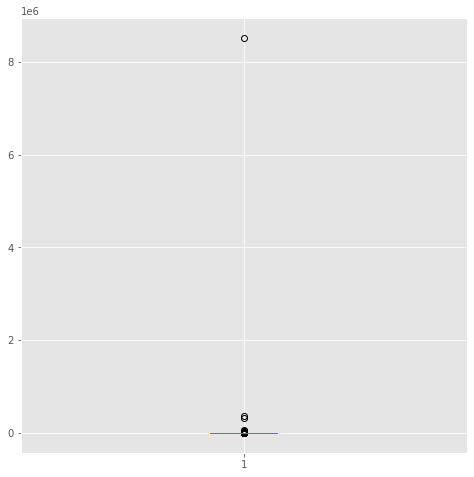

In [24]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.boxplot(preprocessed_df['delivery_time'])
plt.show()

In [25]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(preprocessed_df, test_size=0.1, random_state=0)

In [26]:
quartile_1 = train_df['delivery_time'].quantile(0.10)
quartile_3 = train_df['delivery_time'].quantile(0.90)

train_df = train_df[(train_df['delivery_time'] >= quartile_1) & (train_df['delivery_time'] <= quartile_3)]

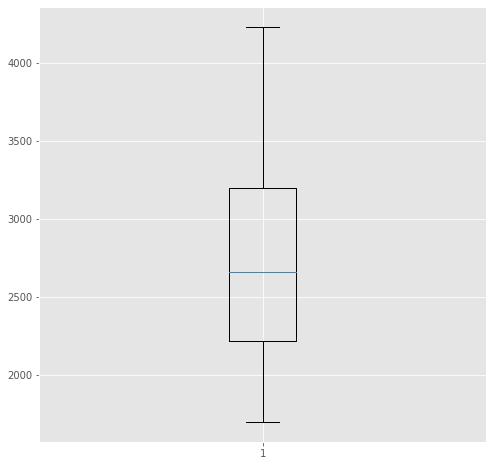

In [27]:
plt.figure(figsize=(8, 8))
plt.boxplot(train_df['delivery_time'])
plt.show()

<hr><br>

##### **Inline Practice 5**  

- 이제 train set과 test set를 모두 준비하였으니 여러분이 사용하고 싶은 모델을 사용하여 학습시켜보세요.
- Categorical Data를 어떻게 처리할 것인지도 잘 생각해보면서 문제를 풀어보세요.
  

- **여러분은 가능한 한 실제 배달 시간과 가까운 값을 예측하되 동시에 under-prediction을 최소화하셔야 합니다.**
- RMSE를 1200 이하로, under-prediction을 0.6 이하로 만들어보세요.

<br><hr>

In [28]:
X_train = train_df.drop(['delivery_time'], axis=1)
y_train = train_df['delivery_time']


X_test = test_df.drop(['delivery_time'], axis=1)
y_test = test_df['delivery_time']

In [29]:
train_df.head()

,store_primary_category,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated,delivery_time,ordered_time,hour_to_categorical
92778,breakfast,2,1695,2,350,1295,114.0,52.0,87.0,421.0,1840.0,1,night
42685,gluten-free,6,2585,6,0,895,20.0,13.0,12.0,654.0,2392.0,1,night
161954,burger,3,1507,2,249,629,72.0,64.0,94.0,933.0,4100.0,2,night
136938,pizza,5,3483,5,479,1079,62.0,65.0,90.0,1063.0,3660.0,3,night
37508,other,20,8456,5,109,999,57.0,57.0,81.0,690.0,2748.0,19,evening


In [30]:
train_df_dummies = pd.get_dummies(train_df)
test_df_dummies = pd.get_dummies(test_df)

In [32]:
train_df_dummies = train_df_dummies.astype({'delivery_time': 'int'})
test_df_dummies = test_df_dummies.astype({'delivery_time': 'int'})

X_train = train_df_dummies.drop(['delivery_time'], axis=1)
y_train = train_df_dummies['delivery_time']


X_test = test_df_dummies.drop(['delivery_time'], axis=1)
y_test = test_df_dummies['delivery_time']

In [33]:
X_train.head()

,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift,total_busy,total_outstanding_orders,estimated,ordered_time,store_primary_category_afghan,...,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,hour_to_categorical_afternoon,hour_to_categorical_evening,hour_to_categorical_morning,hour_to_categorical_night
92778,1695,2,350,1295,114.0,52.0,87.0,421.0,1,0,...,0,0,0,0,0,0,0,0,0,1
42685,2585,6,0,895,20.0,13.0,12.0,654.0,1,0,...,0,0,0,0,0,0,0,0,0,1
161954,1507,2,249,629,72.0,64.0,94.0,933.0,2,0,...,0,0,0,0,0,0,0,0,0,1
136938,3483,5,479,1079,62.0,65.0,90.0,1063.0,3,0,...,0,0,0,0,0,0,0,0,0,1
37508,8456,5,109,999,57.0,57.0,81.0,690.0,19,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
from sklearn.tree import DecisionTreeClassifier  # 다른 decisiontree로 사용해봐도 됨 (어떤 것이 성능이 더 좋을지)

# 의사결정나무 모델링
DT_MODEL = DecisionTreeClassifier(random_state=0)
DT_MODEL.fit(X_train, y_train)

# 예측
prediction = DT_MODEL.predict(X_test)  # test data의 y^hat (예측값)

In [38]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_test, prediction))
rmse

1214.1285473376865

In [42]:
def under_pred(y_test, prediction):
    return sum(prediction < y_test) / len(y_test)

print(under_pred(y_test, prediction))

0.49882451282587115


lightgbm => 10만개 넘을 때, 범주형의 데이터를 알아서 잘 처리해주는 모델 (어느정도 수치형 데이터 있으면)

In [43]:
import lightgbm as lgb

model = lgb.LGBMRegressor()

model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [44]:
rmse = sqrt(mean_squared_error(y_test, prediction))
rmse

1025.0964973528219

In [45]:
print(under_pred(y_test, prediction))

0.46131341100255996


In [54]:
from xgboost import XGBClassifier
import xgboost

model = xgboost.XGBRegressor()

model.fit(X_train, y_train)
prediction = model.predict(X_test)

In [55]:
rmse = sqrt(mean_squared_error(y_test, prediction))
rmse

1016.3905745148156

In [56]:
print(under_pred(y_test, prediction))

0.4628807272347317
